# World Data League 2021: Missing Links - Closing the Circuit in Existing Cycle Networks


## Introduction

Legs and back exercising, immune system reinforcement, blood circulation improvement, brain oxigenation, and hormones segregation are only some benefits of riding bike. Also be so fast to arrive at time to your destination, but so slow to can enjoy the city views.

This is it, in this repository we will tackle bikes as mean of transport. Everyday more people is understanding that cars are not the only way to arrive from one place to another. Of course there are a lot of alternatives, such as public transport, which is the best one when weather is not nice. But cycling is a way of life, makes you independent (you don't depend on schedules or traffic jam), it is not too expensive, everyone can repare it or install new articules at home, for exemple a more comfortable seat, a light dynamo or repare your tyres. These actions make people implicate and then love their bikes. 

Implication and engagement are really important in order to change city transportation. Nowadays, as we will see below, cycling is the less frequent mean of transport, in fact, bikes are mainly understood as a leisure activity. Here the team, we want to encourage people change their minds, let them see that the bicycle is much more than going to Monsanto on sunday with your friends and family.

For that we have developped a descriptive analysis with two targets:

 - To encourage people to change the mean of transport to cycling
 - To reinforce and project new bike infrastructures in Lisbon




The main steps this repository will treat:
 - Lisbonites movility by type of transport.
 - What is GIRA.
 - Current bike infrastructure.
 - Bike loan and bike stations proposal.
 - How to encourage people use bike as mean of transport.
 - How to financiate the project proposals.

## External links and resources

For this stage we have used several external resources:

GIRA stations: https://dados.gov.pt/pt/datasets/gira-bicicletas-de-lisboa-historico/

Train stations localisation: https://opendata.arcgis.com/datasets/4933d8f832474ad2bff558cae59c5207_1.geojson

Metro station localisation:  https://opendata.arcgis.com/datasets/4933d8f832474ad2bff558cae59c5207_2.geojson

Lisbon inclinations: https://github.com/U-Shift/Declives-RedeViaria/tree/main/shapefiles

As well as data from de WDL organization:

https://wdl-data.fra1.digitaloceanspaces.com/u-shift/LisbonDistricts_Geom_Population.geojson

'https://wdl-data.fra1.digitaloceanspaces.com/u-shift/TravelSurveyLisbon.geojson'

'https://wdl-data.fra1.digitaloceanspaces.com/u-shift/LisbonCyclingNetwork.geojson'

In [ ]:
# we need a better version of geopandas for extra functionalities including plotting and geometry intersection
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

In [ ]:
!pip install keplergl
!pip install pygeos
!pip install geopy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json 
import geopandas as gpd

import keplergl as KeplerGl
import pygeos
import geopy

import seaborn as sns
sns.set()

In [ ]:
# Data from WDL
districts0 = gpd.read_file('https://wdl-data.fra1.digitaloceanspaces.com/u-shift/LisbonDistricts_Geom_Population.geojson')
Travelers0 = gpd.read_file('https://wdl-data.fra1.digitaloceanspaces.com/u-shift/TravelSurveyLisbon.geojson')
ciclovias = gpd.read_file('https://wdl-data.fra1.digitaloceanspaces.com/u-shift/LisbonCyclingNetwork.geojson')


In [ ]:
# Inclination information
declives_gdf = gpd.read_file('./sample_data/RedeViariaLisboa_declivesIST.gpkg', sep = ';', encoding = 'ISO-8859-1')


In [ ]:
# Public transport information
train_stations = gpd.read_file('https://opendata.arcgis.com/datasets/4933d8f832474ad2bff558cae59c5207_1.geojson')
metro_stations = gpd.read_file('https://opendata.arcgis.com/datasets/4933d8f832474ad2bff558cae59c5207_2.geojson')

# Importing GIRA files
GIRA_stations_1T = pd.read_excel('https://dados.gov.pt/pt/datasets/r/e1388632-c8e7-4acf-8ddc-c654d66e5b42')
GIRA_stations_2T = pd.read_excel('https://dados.gov.pt/pt/datasets/r/aacfbab2-065d-434b-ae7a-37ea972a6645')
GIRA_stations_3T = pd.read_excel('https://dados.gov.pt/pt/datasets/r/3d896441-0da0-467a-b521-c679509b6553')
GIRA_stations_4T = pd.read_excel('https://dados.gov.pt/pt/datasets/r/decc9e8f-4ff6-4c66-9cd8-334737f0cf84')
GIRA_stations = pd.concat([GIRA_stations_1T, GIRA_stations_2T, GIRA_stations_3T, GIRA_stations_4T])
GIRA_stations=GIRA_stations.drop(2586, axis=0) #2586 has no coordinates!!

In [ ]:
districts = districts0.copy()
districts= districts.to_crs({'init': 'epsg:3857'})

districts["area"] = districts['geometry'].area/ 10**6
districts["densidade"] = districts["Population2011"] / districts["area"]



/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Data cleaning and preparation

WDL organization have provided us three files, districts which contains the polygon limits of each freguesia and 2011 population. Travelers, with the number of daily trips between two freguesias by type of transport, and Ciclovias, which allow us paint the current bike loans.

As always, before the descriptive analysis we watch to the possible missing or outliers data can have. In the table No. 1, we see some distribution statistics for the main Travelers variables. Also we have painted a box plot for the Total variable, which shows some outliers above the percentile 95.

Specially in Bike, distribution data is very acumulated in the low values, the third quartile is 0. That means the 75% of the freguesias conections are not linked by bike users. However we have some extreme values that we have to limit. Our criteria is to limit them to the percentile 95. We prefer to limit them instead delete the lines in order to not lose information. After analysing the same box plots for every transport information we have decided to limit every variable.

In [ ]:
print("Table No. 1")
Travelers0.describe(percentiles=[0.25,0.75,0.8,0.9,0.95,0.99])

,Car,Bike,Walk,Other,Total
count,574.000000,574.000000,574.00000,574.000000,574.000000
mean,575.378049,8.630662,533.60453,407.040070,1524.641115
std,917.808710,39.397728,1909.12336,525.984525,2975.357790
min,0.000000,0.000000,0.00000,0.000000,2.000000
25%,86.250000,0.000000,0.00000,56.500000,257.250000
50%,254.000000,0.000000,23.00000,238.500000,718.000000
75%,631.500000,0.000000,188.50000,525.750000,1659.500000
80%,827.400000,3.000000,330.60000,654.800000,2064.400000
90%,1406.200000,18.000000,1103.10000,1020.100000,3215.700000
95%,2251.500000,32.050000,2130.90000,1406.700000,4679.400000


{'boxes': [<matplotlib.lines.Line2D at 0x7f3c79bf9d10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3c79bfd310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3c79bfe8d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3c79bfe050>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3c79bfb690>,
  <matplotlib.lines.Line2D at 0x7f3c79bfbfd0>]}

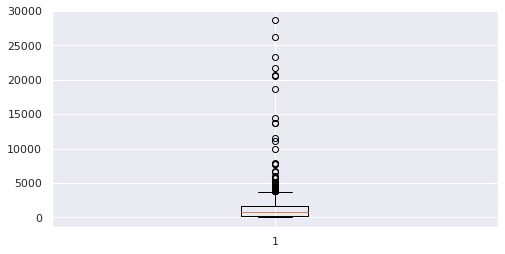

In [ ]:
print("Graph No. 1")
fig = plt.figure(figsize=(8, 4))
plt.boxplot(Travelers0['Total'])

In [ ]:
# Data cleaning
Travelers0.loc[Travelers0['Car'] > 2251 , 'Car'] = 2251
Travelers0.loc[Travelers0['Bike'] > 32 , 'Bike'] = 32
Travelers0.loc[Travelers0['Walk'] > 2130 , 'Walk'] = 2130
Travelers0.loc[Travelers0['Other'] > 1406 , 'Other'] = 1406
Travelers0.loc[Travelers0['Total'] > 4679 , 'Total'] = 4679

Next, we normilize travelers information, because we have the number of daily trips between freguesias, but population is not the same for each one, so we calculate number of trips per person, then we acumulate in months. 

Other situation we have found is that we had the trips from origin to destination, but for us the most important is to know the movility by freguesia, so we add the total monthly trips per person in origin and destination. Now we have the number of total trips by month / person / freguesia. 

Finally, we have joint density and population information.

In [ ]:
# We join Freguesia, density and total population
freguesias = districts[["Dicofre","DistrictName","densidade","Population2011"]]
Travelers = Travelers0.merge(freguesias, left_on = "DicofreOR", right_on = "Dicofre", how = "left").merge(freguesias, left_on = "DicofreDE", right_on = "Dicofre", how = "left")

Travelers = Travelers.rename(columns = {'DistrictName_x':'freg_OR','DistrictName_y':'freg_DE','densidade_x':'densi_OR','densidade_y':'densi_DE',
                                        'Population2011_x':'Pop_OR','Population2011_y':'Pop_DE'})
Travelers = Travelers[["DicofreOR","DicofreDE","freg_OR","freg_DE","Car","Bike","Walk","Other","Total","densi_OR","densi_DE","Pop_OR","Pop_DE","geometry"]]

# We standardize transport utilization by population. Number of trips per freguesia/month/person, adding both Origin and Destination
Travelers["Car_pers_OR"] = 30 * Travelers["Car"] / Travelers["Pop_OR"]
Travelers["Car_pers_DE"] = 30 * Travelers["Car"] / Travelers["Pop_DE"]
Travelers["Car_pers"] = Travelers["Car_pers_OR"] + Travelers["Car_pers_DE"]

Travelers["Bike_pers_OR"] = 30 * Travelers["Bike"] / Travelers["Pop_OR"]
Travelers["Bike_pers_DE"] = 30 * Travelers["Bike"] / Travelers["Pop_DE"]
Travelers["Bike_pers"] = Travelers["Bike_pers_OR"] + Travelers["Bike_pers_DE"]

Travelers["Walk_pers_OR"] = 30 * Travelers["Walk"] / Travelers["Pop_OR"]
Travelers["Walk_pers_DE"] = 30 * Travelers["Walk"] / Travelers["Pop_DE"]
Travelers["Walk_pers"] = Travelers["Walk_pers_OR"] + Travelers["Walk_pers_DE"]

Travelers["Other_pers_OR"] = 30 * Travelers["Other"] / Travelers["Pop_OR"]
Travelers["Other_pers_DE"] = 30 * Travelers["Other"] / Travelers["Pop_DE"]
Travelers["Other_pers"] = Travelers["Other_pers_OR"] + Travelers["Other_pers_DE"]

Travelers["Total_pers_OR"] = 30 * Travelers["Total"] / Travelers["Pop_OR"]
Travelers["Total_pers_DE"] = 30 * Travelers["Total"] / Travelers["Pop_DE"]
Travelers["Total_pers"] = Travelers["Total_pers_OR"] + Travelers["Total_pers_DE"]



Follow, the calculation of the main routes by transport, not considering travels inside the freguesia because we search medium and long distances. For that, we take the top5 connection by freguesia and transport. The goal is to draw in a map which are the main routes the lisbon residents make. This is very interesting because allow us compare the current bike loans with the bike usage and to understand where we need new bike loan segments.

In [ ]:
# Here we calculate the top rutes for every transport
max_top = 5

Top_routes_Car = Travelers[Travelers['freg_OR'] != Travelers['freg_DE']].sort_values("Car", ascending = False)[:max_top]
Top_routes_Car["Top_routes"] = "Car"

Top_routes_Bike = Travelers[Travelers['freg_OR'] != Travelers['freg_DE']].sort_values("Bike", ascending = False)[:max_top]
Top_routes_Bike["Top_routes"] = "Bike"

Top_routes_Walk = Travelers.sort_values("Walk", ascending = False)[:max_top]
Top_routes_Walk["Top_routes"] = "Walk"

Top_routes_Walk = Travelers[Travelers['freg_OR'] != Travelers['freg_DE']].sort_values("Walk", ascending = False)[:max_top]
Top_routes_Walk["Top_routes"] = "Walk"

Top_routes_Other = Travelers[Travelers['freg_OR'] != Travelers['freg_DE']].sort_values("Other", ascending = False)[:max_top]
Top_routes_Other["Top_routes"] = "Other"

Top_routes = Top_routes_Car.merge(Top_routes_Bike, how = 'outer').merge(Top_routes_Walk, how = 'outer').merge(Top_routes_Other, how = 'outer')

print("Table No. 2")
Top_routes_Bike

Table No. 2


,DicofreOR,DicofreDE,freg_OR,freg_DE,Car,Bike,Walk,Other,Total,densi_OR,densi_DE,Pop_OR,Pop_DE,geometry,Car_pers_OR,Car_pers_DE,Car_pers,Bike_pers_OR,Bike_pers_DE,Bike_pers,Walk_pers_OR,Walk_pers_DE,Walk_pers,Other_pers_OR,Other_pers_DE,Other_pers,Total_pers_OR,Total_pers_DE,Total_pers,Top_routes
544,110666,110662,SANTO ANTÓNIO,PARQUE DAS NAÇÕES,274.0,516.0,23.0,169.0,982.0,4799.924393,2442.766824,11836.0,21025.0,"LINESTRING (-9.14980 38.72082, -9.09847 38.77752)",0.694491,0.390963,1.085455,1.307874,0.736266,2.044141,0.058297,0.032818,0.091115,0.428354,0.241141,0.669496,2.489017,1.401189,3.890206,Bike
454,110662,110666,PARQUE DAS NAÇÕES,SANTO ANTÓNIO,580.0,516.0,23.0,174.0,1293.0,2442.766824,4799.924393,21025.0,11836.0,"LINESTRING (-9.09847 38.77752, -9.14980 38.72082)",0.827586,1.470091,2.297677,0.736266,1.307874,2.044141,0.032818,0.058297,0.091115,0.248276,0.441027,0.689303,1.844946,3.277290,5.122236,Bike
154,110618,110654,LUMIAR,ALVALADE,4115.0,335.0,384.0,1860.0,6694.0,4311.790061,3644.517022,45605.0,31813.0,"LINESTRING (-9.16295 38.76838, -9.14454 38.75228)",2.706940,3.880489,6.587429,0.220371,0.315909,0.536279,0.252604,0.362116,0.614720,1.223550,1.754000,2.977550,4.403465,6.312514,10.715978,Bike
246,110654,110618,ALVALADE,LUMIAR,2988.0,314.0,564.0,2743.0,6609.0,3644.517022,4311.790061,31813.0,45605.0,"LINESTRING (-9.14454 38.75228, -9.16295 38.76838)",2.817716,1.965574,4.783290,0.296105,0.206556,0.502662,0.531858,0.371012,0.902870,2.586678,1.804407,4.391086,6.232358,4.347550,10.579907,Bike
274,110655,110654,AREEIRO,ALVALADE,1182.0,128.0,1014.0,477.0,2800.0,6936.098690,3644.517022,20131.0,31813.0,"LINESTRING (-9.13196 38.74159, -9.14454 38.75228)",1.761462,1.114639,2.876101,0.190751,0.120705,0.311456,1.511102,0.956213,2.467315,0.710844,0.449816,1.160660,4.172669,2.640430,6.813099,Bike


Finally we calculate the usage percentage by transport face to Total.

In [ ]:
# Top transport type by freguesia 
Travel_GB = Travelers.groupby(["freg_OR"])["Car_pers","Bike_pers","Walk_pers","Other_pers","Total_pers"].agg(["sum"]).sort_values(('Bike_pers', 'sum'), ascending = False)
Travel_GB = Travel_GB.merge( districts[["DistrictName","Population2011"]], left_on = "freg_OR", right_on = 'DistrictName', how = 'left')

# Rename variables
Travel_GB['Car'] = Travel_GB[('Car_pers', 'sum')]
Travel_GB['Bike'] = Travel_GB[('Bike_pers', 'sum')]
Travel_GB['Walk'] = Travel_GB[('Walk_pers', 'sum')]
Travel_GB['Other'] = Travel_GB[('Other_pers', 'sum')]
Travel_GB['Total'] = Travel_GB[('Total_pers', 'sum')]

# Percentage by transport over Total trips
Travel_GB['Car_%'] = 100 * Travel_GB['Car'] / Travel_GB['Total']
Travel_GB['Bike_%'] = 100 * Travel_GB['Bike'] / Travel_GB['Total']
Travel_GB['Walk_%'] = 100 * Travel_GB['Walk'] / Travel_GB['Total']
Travel_GB['Other_%'] = 100 * Travel_GB['Other'] / Travel_GB['Total']

# Movility classification by freguesia
Travel_GB
Travel_GB.loc[Travel_GB['Total'] <= 60, 'trips_per_day'] = '2 or less daily trips'
Travel_GB.loc[Travel_GB['Total'].between(61,90, inclusive = True), 'trips_per_day'] = '2-3 daily trips'
Travel_GB.loc[Travel_GB['Total'] > 90, 'trips_per_day'] = 'more than 3 daily trips'

Travel_GB = Travel_GB[['DistrictName','Car','Bike','Walk','Other','Total','Car_%','Bike_%','Walk_%','Other_%','trips_per_day']].round(2).set_index('DistrictName')#.sort_values('Bike_%', ascending = False)
print("Table No. 3")
Travel_GB.head(3)

Table No. 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,Car,Bike,Walk,Other,Total,Car_%,Bike_%,Walk_%,Other_%,trips_per_day
DistrictName,,,,,,,,,,
SANTO ANTÓNIO,35.23,3.11,54.34,56.01,148.71,23.69,2.09,36.54,37.66,more than 3 daily trips
PARQUE DAS NAÇÕES,48.06,2.49,15.06,26.20,91.80,52.35,2.71,16.40,28.54,more than 3 daily trips
ALVALADE,62.37,1.65,42.53,39.64,146.19,42.67,1.13,29.09,27.11,more than 3 daily trips


## Explorative and descriptive analysis

We would like to start making a descriptitve analysis, in order to understand which are the transport distributions and the favourite transport by freguesia. 

In the graph below, we represent the total number of monthly trips per person, in blue nbars. In the second axis, bike percentage usage is shown, green line.

Graph No. 2


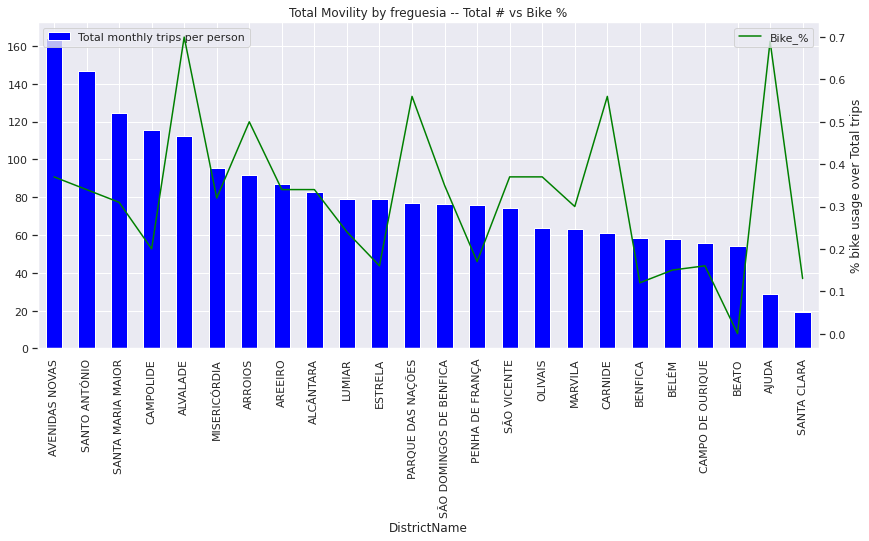

In [ ]:
print("Graph No. 2")
Travel_GB = Travel_GB.sort_values('Total',ascending = False)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
Travel_GB['Total'].plot(kind = 'bar', color = 'blue', ax=ax, label = 'Total monthly trips per person')
ax2 = ax.twinx()
Travel_GB['Bike_%'].plot(kind = 'line', color = 'green', ax=ax2, label  = 'Bike_%')

plt.title('Total Movility by freguesia -- Total # vs Bike %')
plt.ylabel('% bike usage over Total trips')
ax.legend(loc=2)
ax2.legend(loc=1)
plt.grid(False)
plt.show()

We can appreciate that Avenidas Novas, S. António, S.M. Maior, Campolide and Alvalade are the freguesias with highest total movility. It could be caused of Avenidas Novas is the financial center of Lisbon (Marques de Pombal and Amoreiras). On the other hand, Alvalade, Arroios, P. Nações, Carnide and Ajuda have the highest relative bike usage. 

Next, we draw the same total movility face to the rest of transports.

Graph No. 3


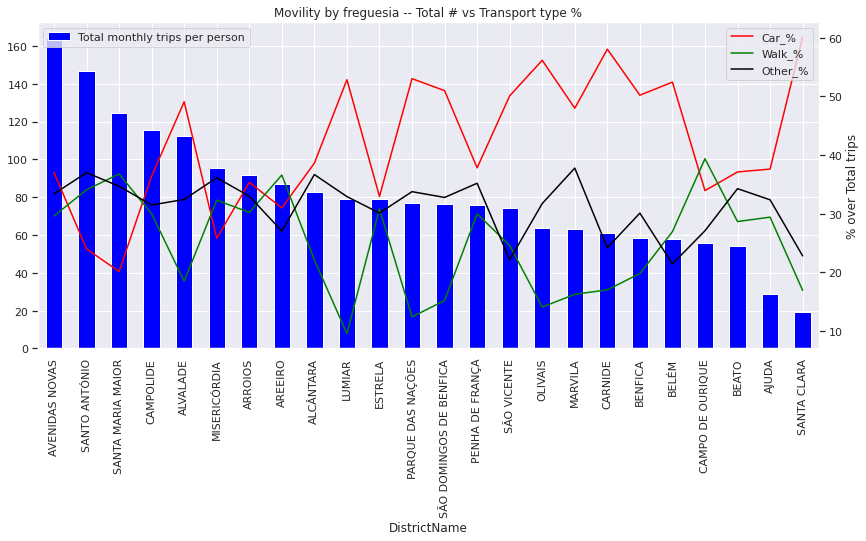

In [ ]:
print("Graph No. 3")
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
Travel_GB['Total'].plot(kind = 'bar', color = 'blue', ax=ax, label = 'Total monthly trips per person')
ax2 = ax.twinx()
#top_bike_movility.plot(kind = 'line', color = 'green', ax=ax2, label  = 'Bike_%')
#Travel_GB['Bike_%'].plot(kind = 'bar', color = 'green', ax=ax2, label  = 'Bike_%')
Travel_GB['Car_%'].plot(kind = 'line', color = 'red', ax=ax2, label  = 'Car_%')
Travel_GB['Walk_%'].plot(kind = 'line', color = 'green', ax=ax2, label  = 'Walk_%')
Travel_GB['Other_%'].plot(kind = 'line', color = 'black', ax=ax2, label  = 'Other_%')
plt.title('Movility by freguesia -- Total # vs Transport type %')
plt.ylabel('% over Total trips')
ax.legend(loc=2)
ax2.legend(loc=1)
plt.grid(False)
plt.show()

Suburb freguesias, as Alvalade, Lumiar, P. Nações, Carnide, S. Clara and Olivais, have the highest Car usage. People from these areas drive more than the others because they are far away. More than the 50% of the trips made from/to these freguesias are made by car.

Walk usage is indirectly proportional with Car usage. The main Car freguesias are the weakness by walking.

Other transport is not so fluctual. All the freguesias are from 25% to 40%. The most important movilizations of these transports are in A. Novas, S. António and S.M. Maior.

On the other hand we would like to focus on bad trips. In order to find the unnecessary trips (because of their shortness), by car, we represent the main top routes inside the freguesia. Those travels which don't get out of their neighborhoods.

In Campolide, P Nações, A. Novas, Benfica and S. Vicente people make more than 6 inside trips by person and month. As we have seen before these freguesias have high car usage, specially Benfica, P Nações and S. Vicente, with more than 50% of travels made by car.

We recommend here, to take some instructional actions, in order to aware people of the consecuencies of taking the car even for the short trips, and encouraging them to use the bike. We explain better these educational actions.

Graph No. 4


Text(0.5, 0, 'Freguesia')

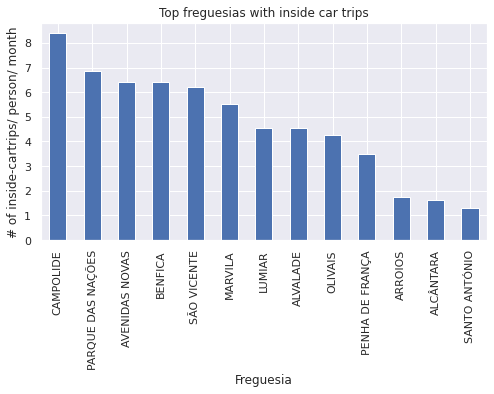

In [ ]:
# These are the "worst" freguesias because the use their cars to make short trips
print("Graph No. 4")
Top_routes_car_inside = Top_routes[Top_routes['freg_OR'] == Top_routes['freg_DE']].sort_values('Car_pers_OR', ascending = False)

Top_routes_car_inside = Top_routes_car_inside.drop_duplicates(subset = ["freg_OR"]).set_index('freg_OR')
Top_routes_car_inside = Top_routes_car_inside['Car_pers_OR']

fig = plt.figure(figsize=(8, 4))
Top_routes_car_inside.plot(kind = 'bar')
plt.title('Top freguesias with inside car trips')
plt.ylabel('# of inside-cartrips/ person/ month')
plt.xlabel('Freguesia')




## Where can bikers ride
 We currently have 3 main cycling arterias in Lisbon: Riverside, North and Center. In the Map No. 1 we can diferenciate them:

 - Starting in Parque das Nações connecting with Marvila and the entire riverside untill Belém (Except a segment between Terreiro do Paço and Cais de Sodré). 
 - The "North" network, from Olivais to Carnide passing from Lumiar, Alvalade and S.D. Benfica. 
 - In the Center of Lisbon there is another big network, from S.Antonio to Avenidas Novas, Campolide and Benfica, connecting also with the "North" bike network in Campo Grande. 

In [ ]:
# convert coordinates dictionary in GIRA_stations to a useful geopandas geometry
# Recuperate the freguesia of every bike station
lat = []
long = []
for values in GIRA_stations.position.items():
  a = values[1][17:27].split(',')[0]
  b = values[1][22:38].split(',')[1].split(']')[0].strip(' ')
  lat.append(a)
  long.append(b)


df_lat = pd.DataFrame(lat)
df_long = pd.DataFrame(long)
df = pd.concat([df_lat,df_long], axis=1)
df.columns = ['lat', 'long']
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lat, df.long))

GIRA_stations = GIRA_stations.reset_index().drop('index', axis=1) #reset index because of the row drop above to allow optimal concatenation
GIRA_stations_gdf = pd.concat([GIRA_stations, gdf], axis=1)
GIRA_stations_gdf = gpd.GeoDataFrame(GIRA_stations_gdf)

GIRA_stations_gdf=GIRA_stations_gdf.set_crs('EPSG:4326')
parish_GIRA_stations0 = gpd.sjoin(GIRA_stations_gdf, districts0, op='intersects') 


In [ ]:
# Calculation of several GIRA variables to analyse ocupation
parish_GIRA_stations = parish_GIRA_stations0.copy()
parish_GIRA_stations['station_size'] = parish_GIRA_stations['numbicicletas'] + parish_GIRA_stations['numdocasvacias']
parish_GIRA_stations['ocupation'] = (100 * parish_GIRA_stations['numbicicletas'] / parish_GIRA_stations['station_size']).round(2)

format = "%d/%m/%Y %H:%M"
parish_GIRA_stations['entity_ts'] = pd.to_datetime(parish_GIRA_stations['entity_ts'], format=format)
parish_GIRA_stations['day'] = parish_GIRA_stations['entity_ts'].dt.strftime('%d/%m/%Y')
parish_GIRA_stations['hour'] = parish_GIRA_stations['entity_ts'].dt.strftime('%H').astype(int)
parish_GIRA_stations['month'] = parish_GIRA_stations['entity_ts'].dt.strftime('%m').astype(int)

parish_GIRA_stations.loc[parish_GIRA_stations['hour'].between(6,13, inclusive = True), 'day_period'] = 'morning'
parish_GIRA_stations.loc[parish_GIRA_stations['hour'].between(14,21, inclusive = True), 'day_period'] = 'afternoon'
parish_GIRA_stations.loc[22 <= parish_GIRA_stations['hour'] , 'day_period'] = 'evening'
parish_GIRA_stations.loc[parish_GIRA_stations['hour'] < 6 , 'day_period'] = 'evening'

parish_GIRA_stations['week_day'] = parish_GIRA_stations['entity_ts'].dt.dayofweek.astype(int)
parish_GIRA_stations.loc[parish_GIRA_stations['week_day'] <= 3, 'week_name'] = 'midweek' # monday, thursday, wednesday, tuesday
parish_GIRA_stations.loc[parish_GIRA_stations['week_day'] > 3, 'week_name'] = 'weekend' #friday, saturday, sunday

GIRA_variation = parish_GIRA_stations.groupby(["day","desigcomercial"])["ocupation"].describe()
GIRA_variation["day_variation"] = GIRA_variation["max"] - GIRA_variation["min"]
GIRA_variation = GIRA_variation.reset_index()
parish_GIRA_stations = parish_GIRA_stations.merge(GIRA_variation, how = 'left', left_on = ["desigcomercial","day"], right_on = ["desigcomercial","day"])
parish_GIRA_stations = parish_GIRA_stations[['desigcomercial','DistrictName','geometry','numbicicletas','numdocasvacias','station_size','ocupation','position', 'entity_ts','day','hour','month','day_period','week_day','week_name','day_variation']]
#parish_GIRA_stations

Map No. 1


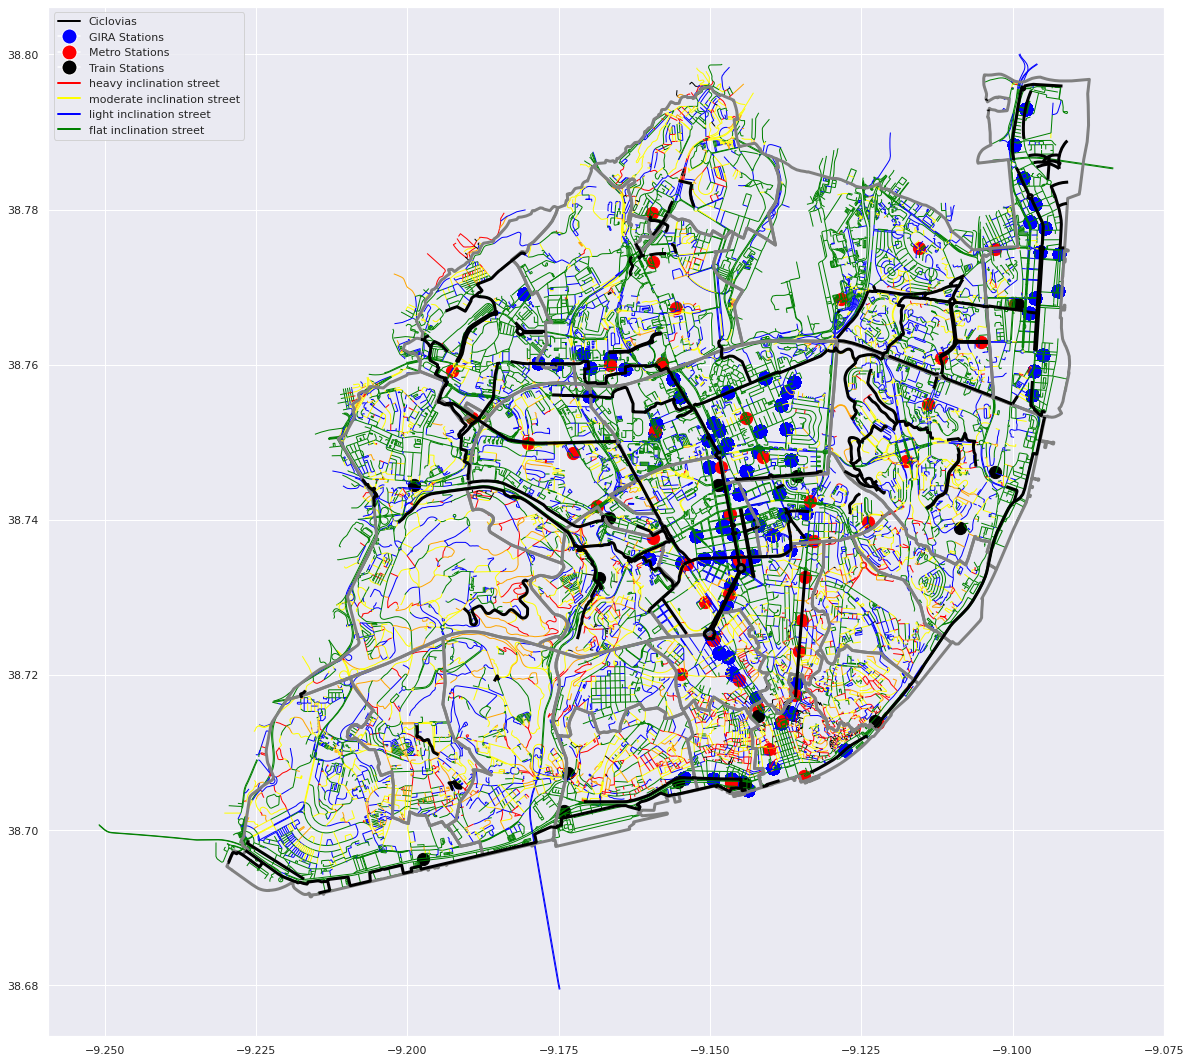

In [ ]:
print("Map No. 1")

from matplotlib.lines import Line2D

# Performing the legend
legend_elements = [Line2D([0], [0], color='black', lw=2, label='Ciclovias'),      #first elemnt
                   Line2D([0], [0], marker='o', color='w', label='GIRA Stations', #second element
                          markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Metro Stations', #third element
                          markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Train Stations',  #fourth element
                          markerfacecolor='black', markersize=15),
                   Line2D([0], [0], color='red', lw=2, label='heavy inclination street'),
                   Line2D([0], [0], color='yellow', lw=2, label='moderate inclination street'),
                   Line2D([0], [0], color='blue', lw=2, label='light inclination street'),
                   Line2D([0], [0], color='green', lw=2, label='flat inclination street'),]

plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(1)
colors = {'0-3: plano':'green', '3-5: leve':'blue', '5-8: médio':'yellow', '8-10: exigente':'orange', '10-20: terrível':'red', '>20: impossível':'black', None: 'white'}

declives_gdf.plot(ax=ax, color=declives_gdf["declive_class"].map(colors), linewidth=1)
districts0.boundary.plot(ax=ax, linewidth=3, color='grey')
ciclovias.plot(ax=ax, color='black', linewidth=3)
GIRA_stations_gdf.plot(ax=ax, color='blue', markersize=150)
metro_stations.plot(ax=ax, color='red', markersize=150)
train_stations.plot(ax=ax, color='black', markersize=150)
ax.legend(handles=legend_elements, loc=2)

plt.show()


In this map we have the inclinations details by street. Green and blue ones indicate that the streets are flat, so they are comfortable to cyclist, then we can install bike loans in there. Yellow and red show the steepest streets. Usability there is lower, so it is not recommendable to put GIRA stations, because people would not use them.

Ciclovias (black lines) are being building around the public transport stations (red and black points).

Throughout the entire "Avenida Liberdade" there are several bike stations, also metro and train's. But there is not a bike loan which allows connect these two freguesias, this avenue is perfect to implement the car-bike-loan with maximum speed at 30 km/h (later we explain this idea). 

If we continue implementing bike loans towards Rossio and Baixa Chiado untill Terreiro do Paço we create a great connection with another metro station and Transtejo fluvial terminal.

Next, we represent the main routes for every transport.

In [ ]:
Mapa_totales= KeplerGl(height=800, weight = 500,
                       data={'Car':Top_routes_Car,'Bike':Top_routes_Bike,'Walk':Top_routes_Walk,
                             'Other':Top_routes_Other,'distritos':districts}) #show the map Mapa_totales


In [ ]:
print("Map No. 2")

Map No. 2



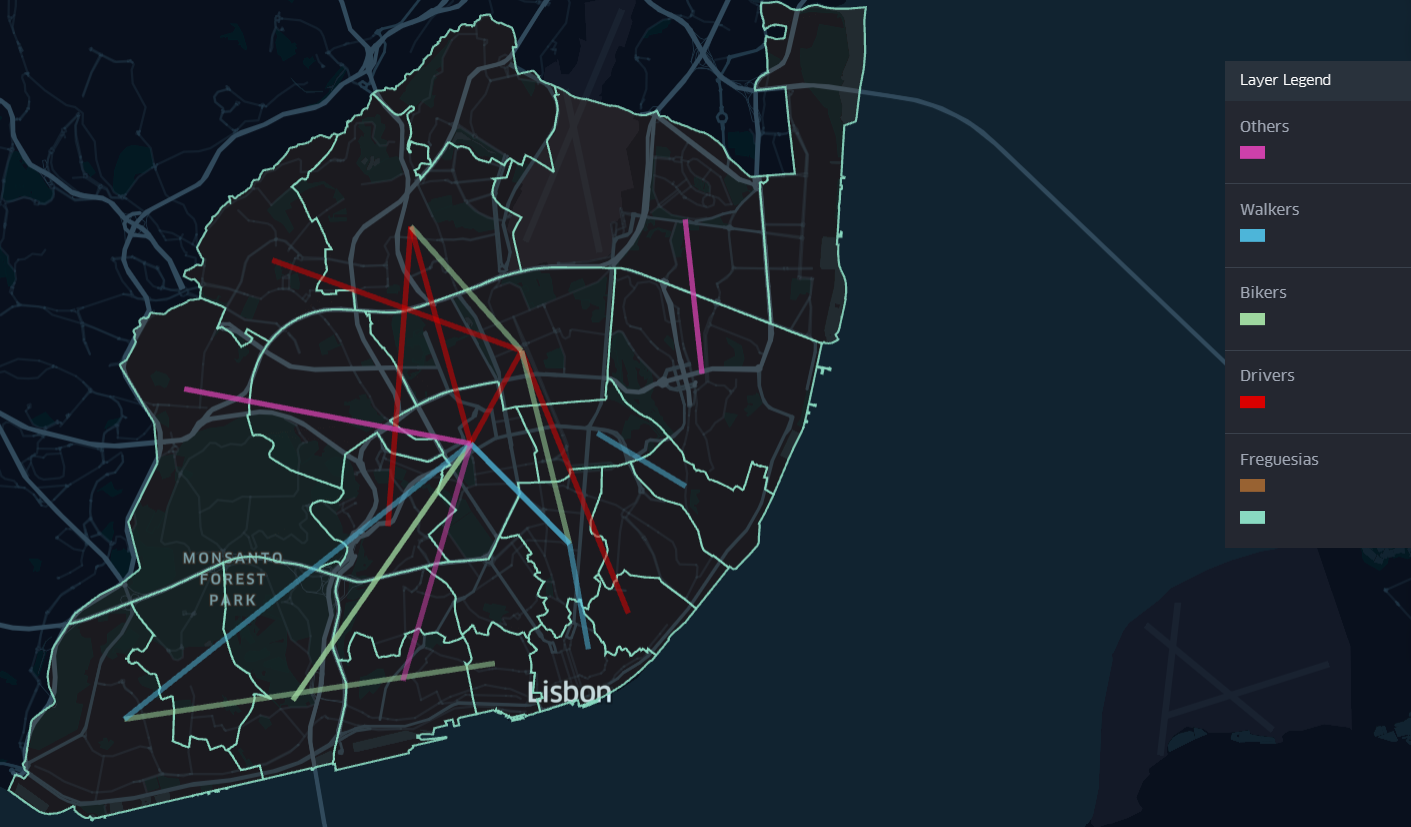


In the Map number 2, we see that Avenidas Novas is, once again, the freguesia which shows the highest movility. From there start main routes for every transport. Conections with Benfica and Estrela are the favourites by bus. By walking they prefer to go to Arroios, and by bike they ride to Alcântara. Drivers came from Alvalade and Lumiar.

For further analysis you can download the entire HTML here :https://drive.google.com/file/d/1H9kkU7cqIdF7toBViUwkPpRN2yvGRvLL/view?usp=sharing






## What is GIRA service

GIRA is a system which allow people to rent bicycles by minutes. Users, through an APP, can activate bikes in any of the available bike stations. Then, after their trip, they can park it in other station. There are more than 80 stations in the city of Lisbon. The payment is made online. User can buy an annual, monthly or daily pass. Project was started in Parque das Nações, and then expanded to the rest of the city.

## How to improve GIRA service

There are two ways to improve GIRA bike service:

 - Install an actualization in the APP which can allow users notice the organization when they find any problem in bikes, before technical team be advertise, before will be the bikes operatives.

 - Pilot program of electric bicycles. Could be interesting test these new bikes specially for two situations. To increase the use of not-young people who can fell laziness when they ride a bike. And also to expand the bike usage not only to the flat streets.

## The benefits of adapting Avenida da Liberdade & Baixa Chiado for the "two wheels"

By allowing bikers ride from Avenida da Liberdade untill Terreiro do Paço and then expanding to Cais de Sodré we achive several benefits to the Lisbon bike network:

 - We eliminate the main Missing Link in the current bike loan network. As a result of implementing a bike road in this big arteria of Lisbon, we join the three main network areas. Specially the Riverside with the Center, which is already connected with the North one. It be also necessary complete the union with Cais de Sodré.

 - We join three of the more important transport centers of Lisbon, Terreiro do paço, Cais de sodré and Marquês de Pombal. Combining train, metro, railway, bus, transtejo fluvial terminal and very soon the bike.

 -  By including transtejo in the equation we allow Caçilhas, Barreiro, Seixal and Montijo people to find other ways to come into the city. It was desiderable to install a new station in Belém fluvial terminal, to also connect people from Porto Brandão and Trafaria.

 - With this new bike loan ampliation  we cover bike trips between Avenidas Novas and Alcântara, which is one of the favourite connection by bike, as we have seen in the Map no. 2. Surrounding the slope between Alcântara and Campolide and Estrela freguesias. Then Belém will benefit of this union.

The bike loans we propose they don't have to be exclusive for bicycles, but shared with other means of transport. The goal is to restrict, in the current streets, the usage of 1 loan, where bikers and motoryzed vehicules could coexist with a maximum speed of 30 km/h. The rest of loans would maintain their characteristics. 

In the streets with only 1 loan, the 30 Km/h limitation would be also carry out for the entire road. The speed restrictions are applied in order to guarantee bikers safety. This proposal allows the "Cámara Municipal de Lisboa" to recycle the current infrastructure and reduce the budget. It also makes less comfortable private car driving and encourage people to use alternatives transports. Finally, lower the speed, lower the greenhouse gases emissions.

## Terreiro do Paço Bike Station

It is mandatory to optimize the number of stations by street or freguesia, as well as the number of bike docks. So, the logic we follow to install stations is to analyse trips frequency and station ocupation and size. 

For exemple, we know that is it necessary to install a bike station at Terreiro do Paço, near metro and fluvial stations, in order to complement the new bike loan we have proposed in the last section. So, we analyse two informations, current usability in the entire freguesia (S. M. Maior) and Cais de Sodré station, because it has similar characteristics, specially regarding to the transtejo fluvial terminal, but also because both of them have bus and metro lines.




In [ ]:
station_needs_OR = Travelers.groupby(["freg_OR"])["Car","Bike","Walk","Other","Total"].agg(["sum"])#.sort_values(('Bike_pers', 'sum'), ascending = False)
station_needs_DE = Travelers.groupby(["freg_DE"])["Car","Bike","Walk","Other","Total"].agg(["sum"])#.sort_values(('Bike_pers', 'sum'), ascending = False)

stations_needs = station_needs_OR.merge(station_needs_DE, how = 'left', left_index = True, right_index = True)

stations_needs["Car"] = stations_needs[('Car_x', 'sum')] + stations_needs[('Car_y', 'sum')]
stations_needs["Bike"] = stations_needs[('Bike_x', 'sum')] + stations_needs[('Bike_y', 'sum')]
stations_needs["Walk"] = stations_needs[('Walk_x', 'sum')] + stations_needs[('Walk_y', 'sum')]
stations_needs["Other"] = stations_needs[('Other_x', 'sum')] + stations_needs[('Other_y', 'sum')]
stations_needs["Total"] = stations_needs[('Total_x', 'sum')] + stations_needs[('Total_y', 'sum')]

stations_needs = stations_needs[['Car','Bike','Walk','Other','Total']]
target_freg_bike_AL = stations_needs[stations_needs.index.isin (['MISERICÓRDIA','SANTA MARIA MAIOR'])]
#target_freg_bike_AL

In [ ]:
target_st_bike_AL = parish_GIRA_stations[parish_GIRA_stations["DistrictName"].isin (['MISERICÓRDIA','SANTA MARIA MAIOR'])]
target_st_bike_AL = target_st_bike_AL[["desigcomercial","DistrictName","station_size", "ocupation"]]

bike_uniq_AL = target_st_bike_AL.drop_duplicates("desigcomercial")
bike_uniq_AL = bike_uniq_AL.groupby(["DistrictName"])[["station_size"]].sum()

target_freg_bike_AL = target_freg_bike_AL.merge(bike_uniq_AL, left_index = True, right_index = True)
target_freg_bike_AL['docks_trip'] = target_freg_bike_AL[('Bike', '')] / target_freg_bike_AL['station_size']

print("Table No. 4")
target_freg_bike_AL

Table No. 4


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(Car, )","(Bike, )","(Walk, )","(Other, )","(Total, )",station_size,docks_trip
freg_OR,,,,,,,
MISERICÓRDIA,13231.0,150.0,16489.0,18377.0,48242.0,82,1.829268
SANTA MARIA MAIOR,12927.0,180.0,33766.0,22429.0,69305.0,120,1.500000


As we see in the Table number 4, number of daily bike trips are not too different between both freguesias. Next, we analyse their bike station characteristics.

In the table No. 5, we see that Cais de sodré station has 22 docks, and its median ocupation shows that it is not saturated. The station size is correct. So, we can copy infrastructure, then, we propose to install a GIRA bike station at Terreiro do Paço with 22 docks.

If we had the movility information about metro and fluvial stations we could estimate the number of new bikers in this area and make better calculations.

In [ ]:
print("Table No. 5")
target_freg_bike_st = parish_GIRA_stations[parish_GIRA_stations["DistrictName"].isin (['MISERICÓRDIA','SANTA MARIA MAIOR'])]
target_freg_bike_st = target_freg_bike_st[["desigcomercial","DistrictName","station_size", "ocupation"]]

target_freg_bike_st.groupby(["DistrictName","desigcomercial","station_size"])[["ocupation"]].median()

Table No. 5


ocupation
DistrictName      desigcomercial                                     station_size           
MISERICÓRDIA      208 - Cais das Pombas                              22                31.82
                  215 - Av. 24 de Julho                              17                17.65
                  216 - Praça D. Luís I                              21                19.05
                  218 - Cais do Sodré                                22                27.27
SANTA MARIA MAIOR 212 - Av. Infante Dom Henrique / Terminal de Cr... 20                35.00
                  219 - Praça do Município                           22                31.82
                  222 - Praça da Figueira                            30                16.67
                  224 - Martim Moniz                                 22                27.27
                  225 - Martim Moniz                                 16                43.75
                  309 - Rua da Palma                                 10                50.00

## Alameda bike station 

Regarding on the previous charts, it is very interesting to install a GIRA station at Arroios because of three reasons:

 - Its bike usage (face to Total) is high. As we see in the Graph No. 2.

 - Because One of the main bike routes goes from Arroios to Alvalade, passing through Areeiro (Map No. 2).

 - Analysing map No. 1, we see that in the Avenida Almirante Reis there is already a bike loan from Martim Moniz to Alameda, but there aren't bike stations except in the beginning (Martim Moniz, which actually is not exactly at Arroios, but in the limit)

So, we propose to install at least one GIRA bike station in this avenue, in order to make use of this bike loan and encourage Arroios residents to use the bike as mean of transport. Next, we justify the capacity of this station.

In [ ]:
stations_needs_AR= stations_needs[['Car','Bike','Walk','Other','Total']]
stations_needs_AR[stations_needs_AR.index.isin (['ARROIOS','SANTO ANTÓNIO'])]

target_freg_bike_AR = parish_GIRA_stations[parish_GIRA_stations["DistrictName"].isin (['ARROIOS','SANTO ANTÓNIO'])]
target_freg_bike_AR = target_freg_bike_AR[["desigcomercial","DistrictName","station_size", "ocupation"]]

bike_st_uniq = target_freg_bike_AR.drop_duplicates("desigcomercial")

target_freg_bike_AR = target_freg_bike_AR.groupby(["DistrictName","desigcomercial","station_size"])[["ocupation"]].median()

bike_st_uniq_AR = bike_st_uniq.groupby(["DistrictName"])[["station_size"]].sum()
bike_st_uniq_AR = bike_st_uniq_AR.merge(stations_needs_AR, left_index = True, right_index = True)
bike_st_uniq_AR['docks_trip'] = bike_st_uniq_AR[('Bike', '')] / bike_st_uniq_AR['station_size']
print("Table No. 6")
bike_st_uniq_AR

Table No. 6


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,station_size,"(Car, )","(Bike, )","(Walk, )","(Other, )","(Total, )",docks_trip
ARROIOS,43,28916.0,615.0,60274.0,32954.0,122761.0,14.302326
SANTO ANTÓNIO,114,17735.0,1523.0,24448.0,27843.0,71551.0,13.359649


In the Table 6, we compare situation at Arroios and Santo António. In this case we compare the bike characteristics face to Santo Antonio because in this freguesia it is Avenida da Liberdade, which is a big avenue like Av. Almirante Reis. It has four GIRA stations, and as we see in the bike column, its bike usage is high (daily bike trips > 1500), so we want to replicate the infrastructure and increase Arroios usage.

We see the addition of every dock for all the stations by Arroios and Santo António freguesias (station_size column), so we know the GIRA capacity in these freguesias. 

Also we have calculated the docks_trip variable, which explains the number of daily trips "asigned" to each dock. In both freguesias is similar.

Next, in Table No. 7, we confirm that ocupation in both freguesias stations is not saturated. In conclusion we recommend to install a GIRA station with 16 docks at Alameda. We have chosen Alameda (and not the other metro stations in Almirante Reis) because of its proximity to the university.

Also here, if we had the Metro passengers intensity we could make a better impact calculation of the new station.

In [ ]:
print("Table No. 7")
target_freg_bike_AR

Table No. 7


ocupation
DistrictName  desigcomercial                                     station_size           
ARROIOS       401 - Rua Martens Ferrão / Av. Fontes Pereira d... 16                31.25
              407 - Praça Duque de Saldanha                      17                17.65
              408 - Praça Duque de Saldanha                      10                30.00
SANTO ANTÓNIO 301 - Avenida da Liberdade / Restauradores         22                36.36
              304 - Avenida da Liberdade / São Jorge             16                31.25
              305 - Avenida da Liberdade / Rua Barata Salgueiro  16                25.00
              306 - Avenida da Liberdade / Rua Alexandre Herc... 16                18.75
              307 - Marquês de Pombal                            33                27.27
              308 - Marquês de Pombal                            11                36.36

## Other possible new bike stations

The map No. 1 shows that the bike usage of Penha de França, Beato and Marvila is very low. Encourage people ride bikes in these areas it is a realistic option because there already exist the bike loan which join Parque das Nações with Terreiro do Paço. The problem here is the absence of GIRA bike stations except in Santa Apolónia, Marvila, Braço de Prata and Moscavide train stations. It is not practical for people from these freguesias to use the bike as mean of transport. Connections with the Airport would also be an interesting survey.

## Other possible bike loans

As we have pointed before, Arroios have potential to increase their bike usage. But it needs to improve their bike infrastructure. We already have proposed a GIRA station, now we recommend to extend the bike loan of Almirante Reis through "Avenida Almirante Gago Coutinho" untill the airport. The avenue is sufficently large to adapt one loan to bikers, sharing with motorised vehicules.



## Cycling is not a trend, it has arrived to stay.

In summary, there is a lot of work to do yet. Bike usage, as we have seen, it is very low. So we have to encourage people to use it. The first thing Lisbon needs to be transformed in a vanguard city, in terms of cycling, is to have a good infrastructure, as we have proposed in the entire repository. For exemple good bike loans connections. The second one is to involucrate people in the change, for that, the education and the change of mind have to be present. From here we want to add some actions that CML, bike institutions and people have to carry out. 

 - Lisbon citizens have to be aware of cycling benefits and also to know the actions that CML is going to take in order to increase bicycle usage. So, we propose to perform an instructional advertising campaign, including publicity in the streets, public transport, and social media. For exemple, get people know the probability of suffering a heart attack differenciated by cyclist and not cyclist. As well, like in packs of cigarettes, we should informate the main consequencies of breathing smoke from car pollution.

 - The instructional actions have to arrive to every social layer, for that, other action we can take is to carry bikes to the schools, so they can play and learn the bike importance in our society as mean of transport. Why are football fields in the school playgrounds and not a little circuit for children ride? The repercusion of this action, may be, it is not instantaneous, but profound. 

 - For adult generations, we have to motivate them to participate in the portuguese bicycle day or in solidarity bike races. During these special days it is important to close the city to cars (maintain only public transport), and allow cyclist and pedestrian take the city. These events create really good atmosphere and bike spirit spreads for the entire city. The inscription race money could be destinated to repare bike city infrastructure.

 - Like in economics with money, higher the number of bikes in the streets higher their utilisation. What we propose in this step is to raffle bicycles and bike complements to GIRA users, bike store clients and trontinettes and carsharing platforms users. These actions will motivate people take their velocipedes.

 - It is mandatory to save the bikers safety; physical safety againts accidents and anti-theft security. In terms of circulation, we have already proposed maximum speed of 30 km/h (when sharing loans with bikes), but also it is necessary to be aware of the importance of wearing helmet, lights and reflector plastics in order to be seen from a safety distance. Regarding the anti-theft systems, it was helpful to install bike parkings in every afluence point of the city, such as supermarkets, schools and universities, offices, churches, parks, public transport stations, bar and restaurant areas, museums and monumental spaces.

 - However, all these politics encourage people to use their bikes in a general way, but one of the main targets of this repository is to establish the bicycle as mean of transport, for that we need entrepreneur implication. With that intention we propose subsides to companies which encourage and financiate their employees came by bike to their jobs. Enterprises help their workers purchase bicycles, then the companies would be fiscally beneficiated.

 - In the most important internet map searcher engines as Google and Bing, you can see where are the metro and train stations, even bus' (in the transport layer). To get people a better knowledge of the bike infrastructure, it would be really interesting to represent in these map searcher engines where are the GIRA stations and the available bike loans.

 - Finally, one of the benefits of biking is that makes us all equals. That's we all use the same engine, our legs. Not diesel, not essence and not horsepower. Also, biking is another mean of transport, another bridge between people, and as we all know, connecting people approach us and eliminates differences. So, it could be another socio-economic factor to equalize people and role out discrimination.

 - Not everything is in the "to do" list, during 2020 CML has supported the "Apoio" program which financiate personal bicycle projects, specially bike purchases and their complementary articles, but also bike reparations. Giving activity to bike stores. Until December 2020 there were financiated more than 3.000 bicylce adquisitions. From here we want to encourage CML continuing with this hopeful program. It is really good to know that bike plannifications is already in the gouvernments agenda, atracting more budget and compromise.


## How to financiate Lisboa Ciclável project

The budget of this project we know it is expensive. We have prpoposed bike stations, streets remodelations, advertising campaigns and an entire infrastructure to make Lisbon a greener city. So, our last idea is how to financiate all these actions and politics. Next, we invite gouvernments, institutions, companies and people colaborate to make the project possible. 

Also we would like to implicate everyone in order to make the iniciative effective. So, it is mandatory to every organism participate in it. This is our financiation program:

 - 40% of public participation, financiated by public organisms, central gouvernment and city council. The implication of these entities is completely necessary.

 - 40% of private participation, by companies like GIRA or Lisbon bike stores. Also we can count on green and animal parties. Because their requirements, in terms of movility, are quite similar than ours. Sportive entities could also be interested in colaborate with the program, because sport activities are contagiuos and then they will have more person enrolled.

 - 20% citizen participation. Based on crowfunding. Little people participations who could have fiscal and usability benefits. This crowfiunding could start by encouraging current GIRA users, which are the main interested. Thanks to publicity actions more people would join the iniciative.

